<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Simula%C3%A7%C3%A3o_motor_gaiola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.753253319729858e-12


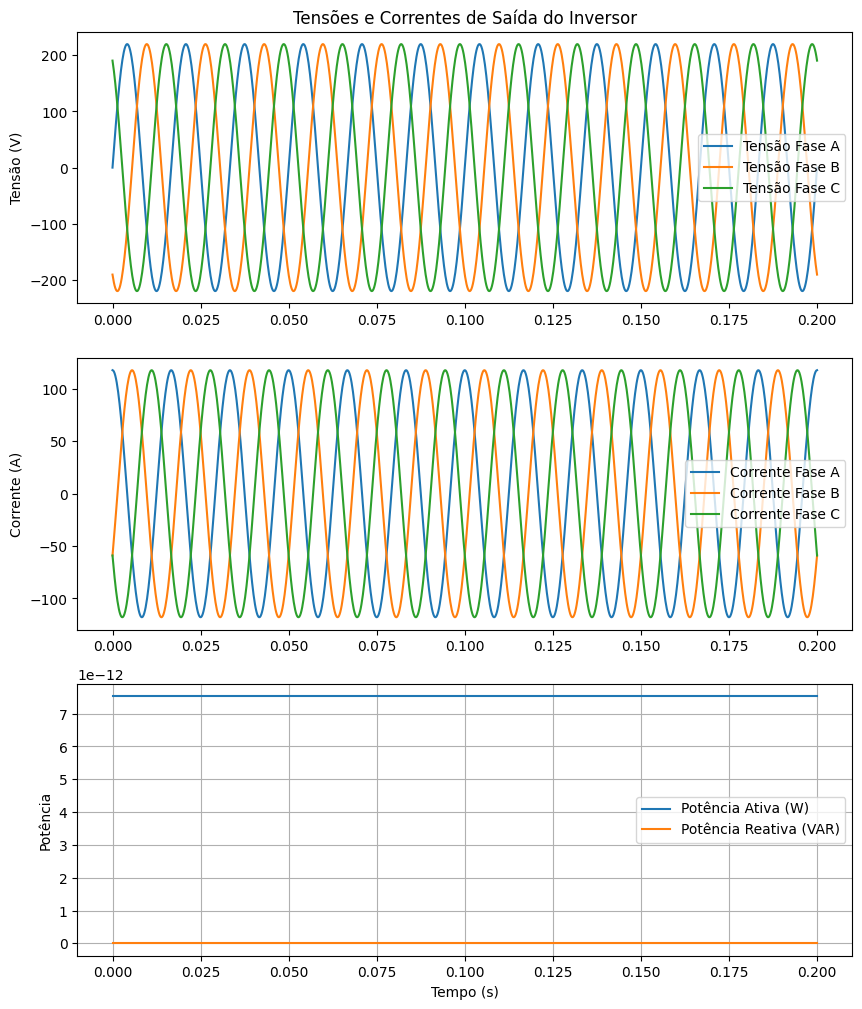

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class InversorWEGCFW300:
    def __init__(self, V_m, f, V_dc, i_dc, phi, theta, f_s, m):
        self.V_m = V_m  # Tensão de entrada RMS (V)
        self.f = f  # Frequência de entrada (Hz)
        self.V_dc = V_dc  # Tensão CC (V)
        self.i_dc = i_dc  # Corrente CC (A)
        self.phi = phi  # Ângulo de fase da tensão de entrada (rad)
        self.theta = theta  # Ângulo de fase da corrente de saída (rad)
        self.f_s = f_s  # Frequência de chaveamento (Hz)
        self.m = m  # Índice de modulação

        # Cálculo do período de chaveamento
        self.T_s = 1 / f_s

        # Cálculo do ângulo de modulação
        self.theta_m = np.arcsin(m)

        # Cálculo da frequência angular de entrada
        self.omega = 2 * np.pi * f

        # Cálculo da tensão de saída fundamental
        self.V_o1 = (2 * V_dc / np.pi) * m

    def gerar_tensoes_saida(self, t):
        u_a = self._gerar_funcao_comutacao(t, self.theta_m)
        u_b = self._gerar_funcao_comutacao(t, self.theta_m + 2 * np.pi / 3)
        u_c = self._gerar_funcao_comutacao(t, self.theta_m + 4 * np.pi / 3)

        v_sw_a = self.V_dc * u_a
        v_sw_b = self.V_dc * u_b
        v_sw_c = self.V_dc * u_c

        v_a = v_sw_a * np.sin(self.omega * t - self.phi)
        v_b = v_sw_b * np.sin(self.omega * t - self.phi - 2 * np.pi / 3)
        v_c = v_sw_c * np.sin(self.omega * t - self.phi + 2 * np.pi / 3)

        return v_a, v_b, v_c

    def gerar_correntes_saida(self, t):
        # Utilizando a mesma forma das tensões, por simplicidade
        i_a, i_b, i_c = self.gerar_tensoes_saida(t)
        i_a = self.i_dc * np.sin(self.omega * t - self.theta + np.pi/2)
        i_b = self.i_dc * np.sin(self.omega * t - self.theta - 2 * np.pi / 3 + np.pi/2)
        i_c = self.i_dc * np.sin(self.omega * t - self.theta + 2 * np.pi / 3 + np.pi/2)
        return i_a, i_b, i_c

    def calcular_potencias(self, v_a, v_b, v_c, i_a, i_b, i_c):
        P = np.mean(v_a * i_a) + np.mean(v_b * i_b) + np.mean(v_c * i_c)
        Q = np.mean(v_a * i_a * np.sin(self.phi)) + np.mean(v_b * i_b * np.sin(self.phi)) + np.mean(v_c * i_c * np.sin(self.phi))
        S = np.sqrt(P**2 + Q**2)
        return P, Q, S

    def _gerar_funcao_comutacao(self, t, theta_m):
        k = np.floor((t + self.T_s / 4) / self.T_s)
        u = (t < (k * self.T_s + theta_m)).astype(int)
        return u

# Parâmetros do inversor
V_m = 700
f = 60
V_dc = 220
i_dc = 118
phi = 0
theta = 0
f_s = 10000
m = 0.01

t_sim = 0.2
t = np.linspace(0, t_sim, 1000)

inversor = InversorWEGCFW300(V_m, f, V_dc, i_dc, phi, theta, f_s, m)

v_a, v_b, v_c = inversor.gerar_tensoes_saida(t)
i_a, i_b, i_c = inversor.gerar_correntes_saida(t)
Pin= np.sqrt(3) * V_dc * i_dc * np.cos(np.pi/2)
print(Pin)
Pa, Q, S = inversor.calcular_potencias(v_a, v_b, v_c, i_a, i_b, i_c)

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(t, v_a, label='Tensão Fase A')
plt.plot(t, v_b, label='Tensão Fase B')
plt.plot(t, v_c, label='Tensão Fase C')
plt.title('Tensões e Correntes de Saída do Inversor')
plt.ylabel('Tensão (V)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, i_a, label='Corrente Fase A')
plt.plot(t, i_b, label='Corrente Fase B')
plt.plot(t, i_c, label='Corrente Fase C')
plt.ylabel('Corrente (A)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.full_like(t, Pa), label='Potência Ativa (W)')
plt.plot(t, np.full_like(t, Q), label='Potência Reativa (VAR)')
#plt.plot(t, np.full_like(t, S), label='Potência Aparente (VA)')
plt.xlabel('Tempo (s)')
plt.ylabel('Potência')
plt.legend()

plt.grid(True)
plt.show()


Escorregamento máximo e torque: s=0.10200000000000001, Torque=1185.33514975608 Nm
Velocidade Sincrona: 188.49555921538757 (rad/s) ou 1800.0RPM


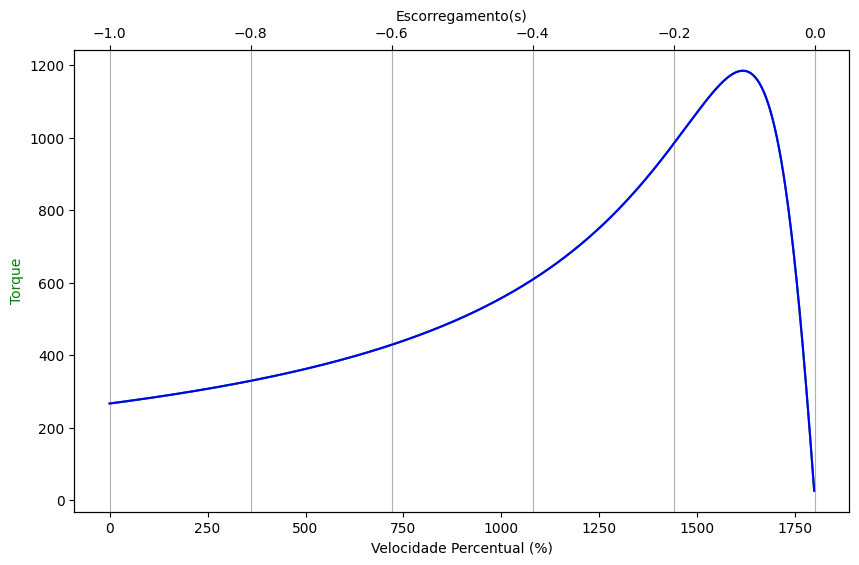

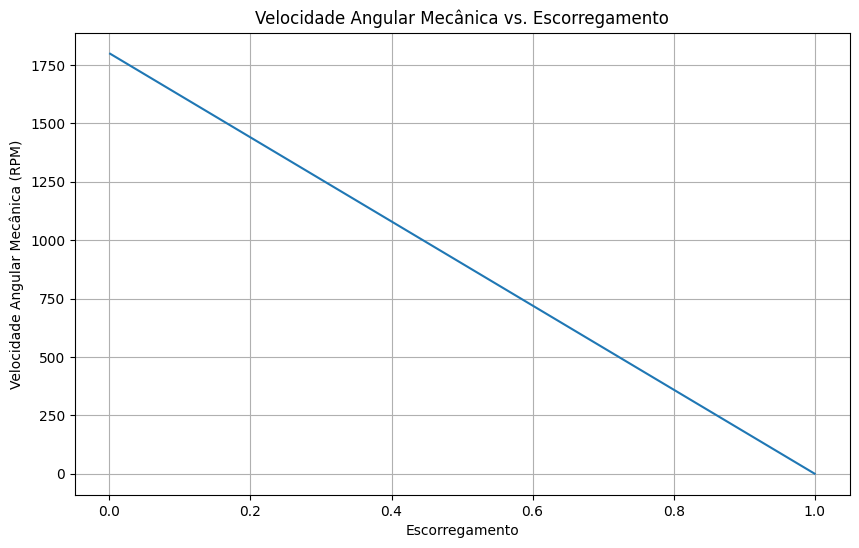

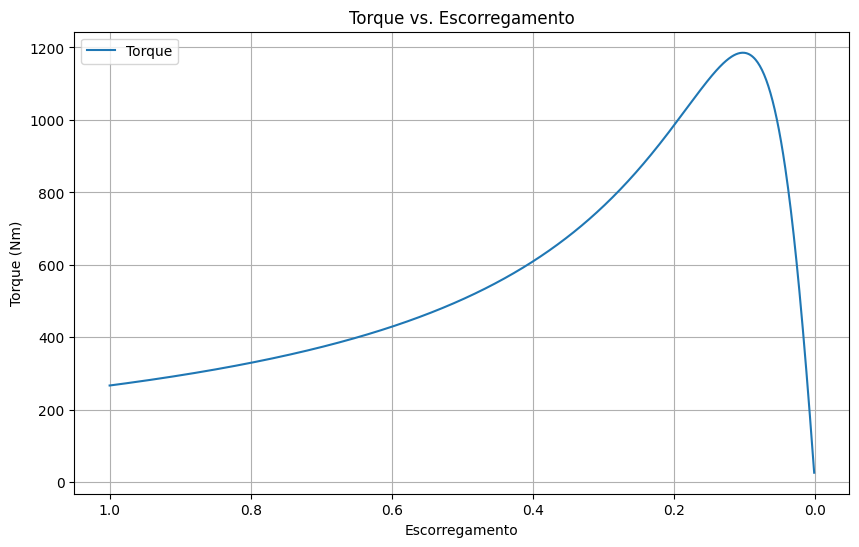

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_partida(self, V_fase):
        Im = self.calcular_tensao_induzida(V_fase, 1) / self.Xm
        I2 = self.calcular_corrente(V_fase, 1) - Im
        return I2

    def calcular_torque(self, V_fase, s):
        # Corrente do rotor
        Z_total = self.calcular_impedancia(s)[0]
        I_1 = V_fase / Z_total  # Corrente do estator

        # Tensão no rotor
        Z1 = self.calcular_impedancia(s)[1]
        E2 = V_fase - I_1 * Z1  # Tensão induzida no rotor

        # Corrente do rotor
        I2 = E2 / (self.R2 / s + complex(0, self.X2))

        # Potência no rotor e torque
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / self.w_s

        return self.K * torque  # Aplica a constante de proporcionalidade

    def encontrar_maior_torque(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        max_torque = max(torques)
        max_s = escorregamentos[torques.index(max_torque)]
        return max_s, max_torque

    def calcular_velocidade_angular(self, escorregamentos):
        return (self.w_s * (1 - escorregamentos)) * (30 / np.pi)

    def simular_desempenho(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        plt.figure(figsize=(10, 5))
        plt.plot(escorregamentos, torques, label='Torque (Nm)')
        plt.title('Torque vs. Escorregamento')
        plt.xlabel('Escorregamento')
        plt.ylabel('Torque (Nm)')
        plt.grid(True)
        plt.show()

# Exemplo de uso
frequencia = 60  # frequência em Hz
P = 4  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 0.95  # Constante de proporcionalidade para o torque ajustada para exemplo

# Instanciação do motor
motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Tensão aplicada (exemplo)
V_fase = V_m / np.sqrt(3)  # Tensão de fase (V) a partir de uma tensão de linha de 220V


# Simular o desempenho do motor para uma faixa de escorregamentos
escorregamentos = np.linspace(0.001, 1, 1000)
torques = [motor.calcular_torque(V_fase, s) for s in escorregamentos]

# Encontrar maior torque
s_max, torque_max = motor.encontrar_maior_torque(V_fase, escorregamentos)

print(f"Escorregamento máximo e torque: s={s_max}, Torque={torque_max} Nm")
print(f"Velocidade Sincrona: {motor.w_s} (rad/s) ou {(motor.w_s)*30/np.pi}RPM")

# Calcular a velocidade percentual
velocidades_percentuais = (1 - escorregamentos) * ((motor.w_s)*30/np.pi)

esp=np.abs(-escorregamentos)

# Plotagem de Torque vs. Velocidade Percentual
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotar dados no primeiro eixo
ax1.plot(velocidades_percentuais,torques, 'g-')
ax1.set_xlabel('Velocidade Percentual (%)')
ax1.set_ylabel('Torque', color='g')
# Adicionar um segundo eixo x em cima
ax2 = ax1.twiny()
ax2.plot(-esp, torques, 'b-')
ax2.set_xlabel('Escorregamento(s)')
plt.grid(True)
plt.show()

print('\n')

# Calcular e plotar a velocidade angular mecânica vs. escorregamento
velocidades_angulares = motor.calcular_velocidade_angular(escorregamentos)

plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, velocidades_angulares)
plt.title('Velocidade Angular Mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Velocidade Angular Mecânica (RPM)')
plt.grid(True)
plt.show()

print('\n')

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, torques, label='Torque')
plt.title('Torque vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


<ipython-input-12-de0260618464>:18: RuntimeWarning: divide by zero encountered in scalar divide
  return np.cos(np.arctan((np.abs(s) * self.L2 - self.L1) / (self.R2 * np.abs(s))))


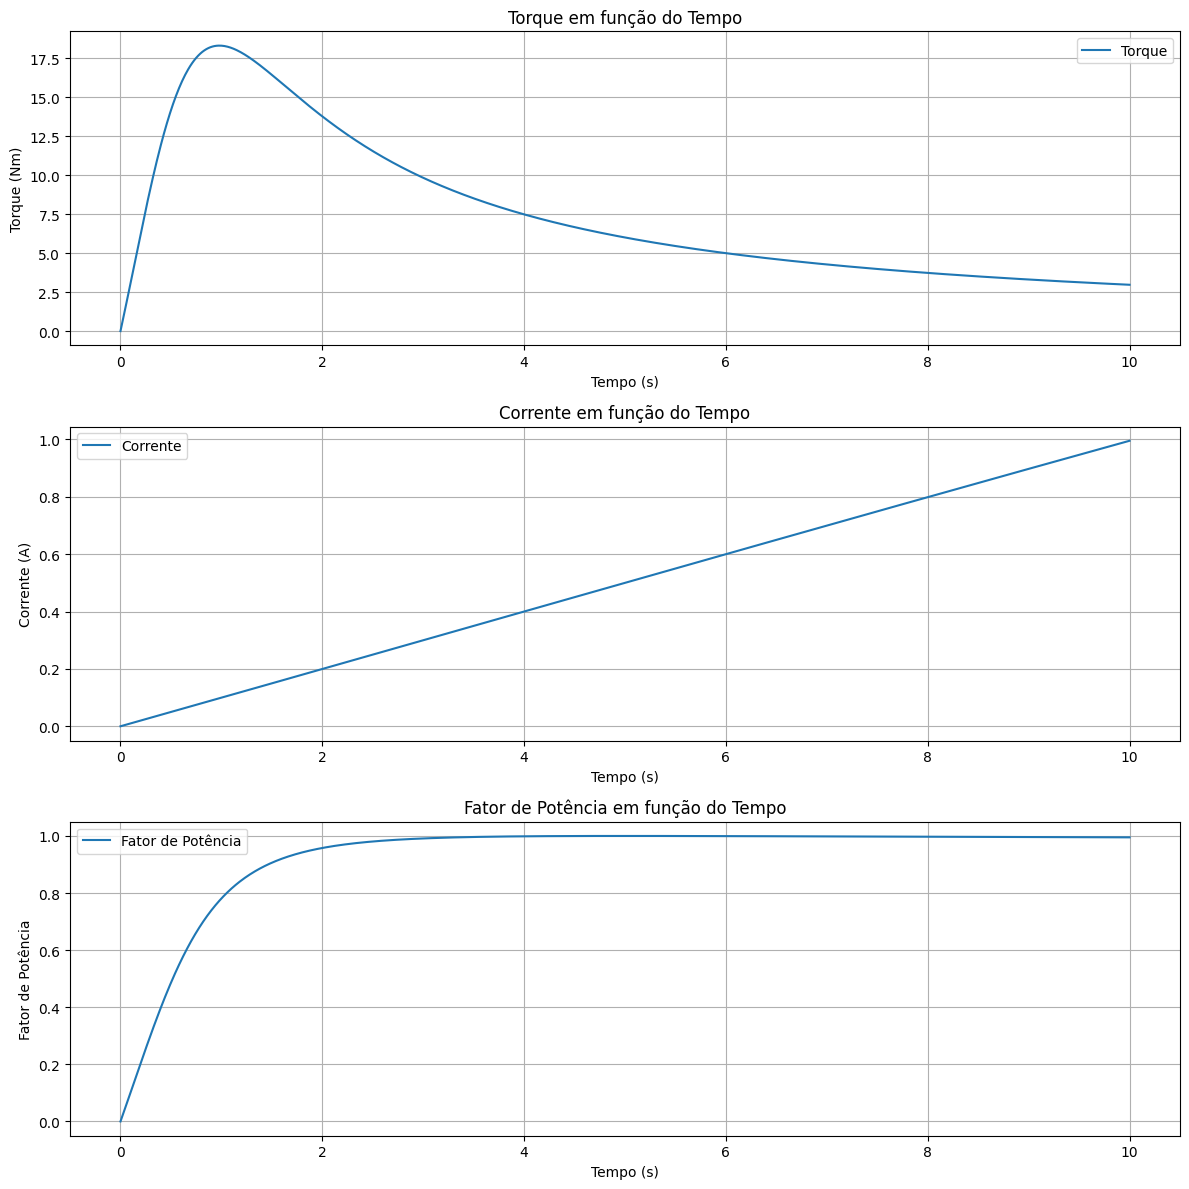

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class MotorDeGaiola:
    def __init__(self, R1, R2, L1, L2):
        self.R1 = R1  # Resistência do rotor
        self.R2 = R2  # Resistência do estator
        self.L1 = L1  # Indutância do rotor
        self.L2 = L2  # Indutância do estator

    def calcular_torque(self, s):
        return (3 * self.R2 * np.abs(s)) / (np.abs(s)**2 * self.R2**2 + (np.abs(s) * self.L2 - self.L1)**2)

    def calcular_corrente(self, s):
        return (self.R2 * np.abs(s)) / np.sqrt(self.R2**2 + (np.abs(s) * self.L2 - self.L1)**2)

    def calcular_fator_potencia(self, s):
        return np.cos(np.arctan((np.abs(s) * self.L2 - self.L1) / (self.R2 * np.abs(s))))

    def simular_motor(self, t_final, num_steps):
        t = np.linspace(0, t_final, num_steps)
        s = np.linspace(0, 1, num_steps)  # O escorregamento varia de 0 a 1 durante o tempo de simulação

        corrente = [self.calcular_corrente(si) for si in s]
        torque = [self.calcular_torque(si) for si in s]
        fator_potencia = [self.calcular_fator_potencia(si) for si in s]

        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        plt.plot(t, torque, label='Torque')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Torque (Nm)')
        plt.title('Torque em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(t, corrente, label='Corrente')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Corrente (A)')
        plt.title('Corrente em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(t, fator_potencia, label='Fator de Potência')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Fator de Potência')
        plt.title('Fator de Potência em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# Parâmetros do motor
R1 = 1
R2 = 1
L1 = 0.1
L2 = 0.2

# Criar instância do Motor de Gaiola
motor = MotorDeGaiola(R1, R2, L1, L2)

# Simular o motor
motor.simular_motor(t_final=10, num_steps=1000)
